In [67]:
import pandas as pd
import json
import spacy
import networkx as nx
import pygraphviz as pgv
from IPython.display import Image, display
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import os





In [ ]:


# Load the spaCy language model (English model)
nlp = spacy.load("en_core_web_sm") 


In [13]:
parsed_file = r"C:\Users\MSC\OneDrive - Fraunhofer Austria Research GmbH\Desktop\NLP\data\headlines_depency_parsed.json"  # Replace with your actual file path

with open(parsed_file, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df = df.drop(columns=["article_link"])

df.head()

,is_sarcastic,headline,pos_tags,syntax_tree
0,1,thirtysomething scientists unveil doomsday clo...,"[{'text': 'thirtysomething', 'pos': 'ADJ', 'de...","[{'text': 'thirtysomething', 'dep': 'amod', 'c..."
1,0,dem rep. totally nails why congress is falling...,"[{'text': 'dem', 'pos': 'PROPN', 'dep': 'intj'...","[{'text': 'dem', 'dep': 'intj', 'children': []..."
2,0,eat your veggies: 9 deliciously different recipes,"[{'text': 'eat', 'pos': 'VERB', 'dep': 'ROOT',...","[{'text': 'eat', 'dep': 'ROOT', 'children': ['..."
3,1,inclement weather prevents liar from getting t...,"[{'text': 'inclement', 'pos': 'NOUN', 'dep': '...","[{'text': 'inclement', 'dep': 'compound', 'chi..."
4,1,mother comes pretty close to using word 'strea...,"[{'text': 'mother', 'pos': 'NOUN', 'dep': 'nsu...","[{'text': 'mother', 'dep': 'nsubj', 'children'..."


In [49]:
def visualize_dependency_tree(text):
    """
    Visualize the dependency tree for a given text using spaCy's displacy.
    """
    # Process the text with spaCy
    doc = nlp(text)
    
    # Display the dependency tree
    spacy.displacy.render(doc, style="dep", jupyter=True)

def visualize_literal_tree(text, pos_tags=True):
    """
    Visualize the dependency tree as a literal tree structure using pygraphviz.
    If pos_tags is True, display POS tags instead of tokens in the tree.
    
    Args:
    - text (str): The text to visualize the dependency tree for.
    - pos_tags (bool): Whether to display POS tags instead of the token text (default is False).
    """
    # Process the text with spaCy
    doc = nlp(text)
    
    # Create a new directed graph
    G = pgv.AGraph(strict=False, directed=True)

    # Add nodes and edges based on the dependency parsing
    for token in doc:
        # If pos_tags is True, display POS tags; otherwise, display the token text
        label = f"{token.text}\n({token.pos_})" if pos_tags else token.text
        G.add_node(token.i, label=label)
        if token.head != token:
            G.add_edge(token.head.i, token.i)

    # Render the tree
    G.layout(prog="dot")
    
    # Display the tree
    output_path = r"C:\Users\MSC\OneDrive - Fraunhofer Austria Research GmbH\Desktop\NLP\tmp\dependency_tree.png"
    G.draw(output_path)
    display(Image(output_path))



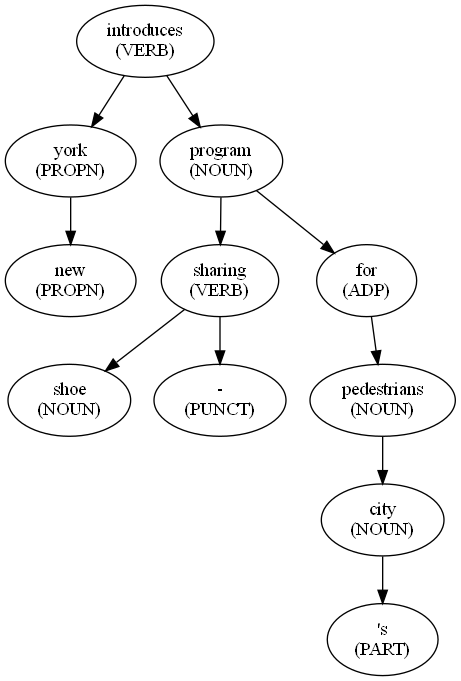

In [54]:
ind = 34
visualize_dependency_tree(df.loc[ind, "headline"])
visualize_literal_tree(df.loc[ind, "headline"])


In [59]:
def feature_engineering(df):
    # Define a list of functional words (POS tags)
    func_pos_tags = ['ADP', 'AUX', 'CCONJ', 'DET', 'PART', 'PUNCT', 'SCONJ']
    
    # Identify the 7 most common POS tags (can be adjusted as needed)
    common_pos_tags = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'PROPN']

    # Initialize lists to store the feature values
    ratio_func_words = []
    ratio_unique_pos = []
    lengths = []
    pos_repetitions = []
    
    # Initialize a dictionary to store the ratios for each POS tag
    pos_tag_ratios = {pos_tag: [] for pos_tag in common_pos_tags}

    # Iterate through the dataframe rows
    for _, row in df.iterrows():
        headline = row['headline']
        doc = nlp(headline)
        
        # Calculate total words in the sentence
        total_words = len(doc)
        
        # Calculate ratio_func_words
        func_words = sum(1 for token in doc if token.pos_ in func_pos_tags)
        ratio_func_words.append(func_words / total_words if total_words > 0 else 0)

        # Calculate ratio_unique_pos
        unique_pos = len(set(token.pos_ for token in doc))
        ratio_unique_pos.append(unique_pos / total_words if total_words > 0 else 0)

        # Calculate length
        lengths.append(total_words)

        # Calculate pos_repetitions (check for consecutive POS tag repetitions)
        pos_repetition_found = any(doc[i].pos_ == doc[i+1].pos_ for i in range(len(doc)-1))
        pos_repetitions.append(1 if pos_repetition_found else 0)
        
        # Calculate ratios for the 7 most common POS tags
        for pos_tag in common_pos_tags:
            tag_count = sum(1 for token in doc if token.pos_ == pos_tag)
            pos_tag_ratios[pos_tag].append(tag_count / total_words if total_words > 0 else 0)

    # Add the new features to the dataframe
    df['ratio_func_words'] = ratio_func_words
    df['ratio_unique_pos'] = ratio_unique_pos
    df['length'] = lengths
    df['pos_repetitions'] = pos_repetitions

    # Add the POS tag ratios to the dataframe
    for pos_tag in common_pos_tags:
        df[f'ratio_{pos_tag.lower()}'] = pos_tag_ratios[pos_tag]

    return df


In [60]:
# Apply feature engineering to the dataframe
df = feature_engineering(df)

# Display the updated dataframe with the new features
df.head()

,is_sarcastic,headline,pos_tags,syntax_tree,ratio_func_words,ratio_unique_pos,length,pos_repetitions,ratio_noun,ratio_verb,ratio_adj,ratio_adv,ratio_pron,ratio_propn,ratio_num
0,1,thirtysomething scientists unveil doomsday clo...,"[{'text': 'thirtysomething', 'pos': 'ADJ', 'de...","[{'text': 'thirtysomething', 'dep': 'amod', 'c...",0.125000,0.625000,8,1,0.500000,0.125000,0.125000,0.000000,0.000,0.125000,0.000
1,0,dem rep. totally nails why congress is falling...,"[{'text': 'dem', 'pos': 'PROPN', 'dep': 'intj'...","[{'text': 'dem', 'dep': 'intj', 'children': []...",0.266667,0.600000,15,1,0.133333,0.133333,0.133333,0.066667,0.000,0.266667,0.000
2,0,eat your veggies: 9 deliciously different recipes,"[{'text': 'eat', 'pos': 'VERB', 'dep': 'ROOT',...","[{'text': 'eat', 'dep': 'ROOT', 'children': ['...",0.125000,0.875000,8,0,0.250000,0.125000,0.125000,0.125000,0.125,0.000000,0.125
3,1,inclement weather prevents liar from getting t...,"[{'text': 'inclement', 'pos': 'NOUN', 'dep': '...","[{'text': 'inclement', 'dep': 'compound', 'chi...",0.250000,0.500000,8,1,0.375000,0.375000,0.000000,0.000000,0.000,0.000000,0.000
4,1,mother comes pretty close to using word 'strea...,"[{'text': 'mother', 'pos': 'NOUN', 'dep': 'nsu...","[{'text': 'mother', 'dep': 'nsubj', 'children'...",0.272727,0.454545,11,1,0.181818,0.272727,0.000000,0.272727,0.000,0.000000,0.000


In [61]:
def calculate_syntactic_complexity(doc):
    """
    Calculate the syntactic complexity of a sentence based on its dependency tree.
    Syntactic complexity is defined as a combination of tree depth and average branching factor.
    This function scales the complexity score from 0 to 1.
    """
    
    # Calculate the depth of the syntactic tree
    def get_tree_depth(token):
        if not any(child for child in token.children):  # If the token has no children, it's a leaf
            return 1
        return 1 + max(get_tree_depth(child) for child in token.children)
    
    # Get the root token (typically the main verb or root of the sentence)
    root_token = [token for token in doc if token.dep_ == 'ROOT'][0]
    
    # Calculate the depth from the root
    tree_depth = get_tree_depth(root_token)
    
    # Calculate the average branching factor
    total_children = sum(len([child for child in token.children]) for token in doc)
    num_non_leaf_nodes = sum(1 for token in doc if len([child for child in token.children]) > 0)
    average_branching_factor = total_children / num_non_leaf_nodes if num_non_leaf_nodes > 0 else 0
    
    # Normalize tree depth and branching factor to the range [0, 1]
    max_tree_depth = 10  # Adjust based on your data, can be higher for more complex sentences
    max_branching_factor = 5  # Adjust based on expected branching in the data
    
    # Normalize tree depth and average branching factor
    normalized_depth = min(tree_depth / max_tree_depth, 1)
    normalized_branching = min(average_branching_factor / max_branching_factor, 1)
    
    # Return the calculated features (including depth and branching factor)
    return normalized_depth, normalized_branching, tree_depth, average_branching_factor


# Define a function to add the syntactic features to the dataframe
def add_syntactic_features(df):
    # Initialize empty lists to store feature values
    depths = []
    branching_factors = []
    normalized_depths = []
    normalized_branching_factors = []

    # Iterate through the dataframe and compute the syntactic features for each headline
    for _, row in df.iterrows():
        headline = row['headline']
        doc = nlp(headline)  # Process the headline with spaCy
        
        # Calculate syntactic features for the current headline
        normalized_depth, normalized_branching, depth, branching_factor = calculate_syntactic_complexity(doc)
        
        # Append the values to the respective lists
        normalized_depths.append(normalized_depth)
        normalized_branching_factors.append(normalized_branching)
        depths.append(depth)
        branching_factors.append(branching_factor)

    # Add the new features to the dataframe
    df['syntactic_depth'] = depths
    df['branching_factor'] = branching_factors
    #df['normalized_depth'] = normalized_depths
    #df['normalized_branching_factor'] = normalized_branching_factors

    return df



In [62]:


# Example usage: Assuming df is your DataFrame
df = add_syntactic_features(df)

# Display the updated dataframe with the new syntactic features
display(df.head())


,is_sarcastic,headline,pos_tags,syntax_tree,ratio_func_words,ratio_unique_pos,length,pos_repetitions,ratio_noun,ratio_verb,ratio_adj,ratio_adv,ratio_pron,ratio_propn,ratio_num,syntactic_depth,branching_factor
0,1,thirtysomething scientists unveil doomsday clo...,"[{'text': 'thirtysomething', 'pos': 'ADJ', 'de...","[{'text': 'thirtysomething', 'dep': 'amod', 'c...",0.125000,0.625000,8,1,0.500000,0.125000,0.125000,0.000000,0.000,0.125000,0.000,5,1.400000
1,0,dem rep. totally nails why congress is falling...,"[{'text': 'dem', 'pos': 'PROPN', 'dep': 'intj'...","[{'text': 'dem', 'dep': 'intj', 'children': []...",0.266667,0.600000,15,1,0.133333,0.133333,0.133333,0.066667,0.000,0.266667,0.000,6,2.800000
2,0,eat your veggies: 9 deliciously different recipes,"[{'text': 'eat', 'pos': 'VERB', 'dep': 'ROOT',...","[{'text': 'eat', 'dep': 'ROOT', 'children': ['...",0.125000,0.875000,8,0,0.250000,0.125000,0.125000,0.125000,0.125,0.000000,0.125,4,1.750000
3,1,inclement weather prevents liar from getting t...,"[{'text': 'inclement', 'pos': 'NOUN', 'dep': '...","[{'text': 'inclement', 'dep': 'compound', 'chi...",0.250000,0.500000,8,1,0.375000,0.375000,0.000000,0.000000,0.000,0.000000,0.000,6,1.166667
4,1,mother comes pretty close to using word 'strea...,"[{'text': 'mother', 'pos': 'NOUN', 'dep': 'nsu...","[{'text': 'mother', 'dep': 'nsubj', 'children'...",0.272727,0.454545,11,1,0.181818,0.272727,0.000000,0.272727,0.000,0.000000,0.000,6,2.000000


In [64]:
# Load GPT-2 Model and Tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Function to calculate the probability of a word in context using GPT-2
def get_word_probabilities(sentence):
    # Tokenize the input sentence
    tokens = tokenizer.encode(sentence, return_tensors="pt")
    
    # Get the model's output (logits) for the sentence
    with torch.no_grad():
        outputs = model(tokens)
    logits = outputs.logits.squeeze()
    
    # Calculate the probability for each word in the sentence
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
    # Decode the tokens back to words
    decoded_tokens = tokenizer.convert_ids_to_tokens(tokens[0])
    
    word_probabilities = {}
    
    # For each word, find the probability
    for i, token in enumerate(decoded_tokens[1:]):  # Start from 1 to skip the beginning token
        word_probabilities[token] = probabilities[i, tokenizer.convert_tokens_to_ids(token)].item()
    
    return word_probabilities

# Function to calculate the features
def calculate_surprisingness_features(df):
    reversed_probabilities = []
    average_surprisingness = []
    
    # Iterate through the dataframe rows
    for _, row in df.iterrows():
        headline = row['headline']
        
        # Get the word probabilities for the headline
        word_probabilities = get_word_probabilities(headline)
        
        # Calculate reversed probability (1 - p) for the most surprising word
        most_surprising_word = max(word_probabilities, key=word_probabilities.get)
        most_surprising_probability = word_probabilities[most_surprising_word]
        reversed_probability = 1 - most_surprising_probability
        
        # Calculate the average surprisingness (1 - p) for all words
        avg_surprisingness = sum([1 - prob for prob in word_probabilities.values()]) / len(word_probabilities)
        
        # Append the results to the feature lists
        reversed_probabilities.append(reversed_probability)
        average_surprisingness.append(avg_surprisingness)
    
    # Add the new features to the dataframe
    df['reversed_probability'] = reversed_probabilities
    df['average_surprisingness'] = average_surprisingness

    return df


c:\Users\MSC\.conda\envs\venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MSC\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [65]:
# Example usage: Assuming df is your DataFrame
df = calculate_surprisingness_features(df)

# Display the updated dataframe with the new surprisingness features
df.head()

,is_sarcastic,headline,pos_tags,syntax_tree,ratio_func_words,ratio_unique_pos,length,pos_repetitions,ratio_noun,ratio_verb,ratio_adj,ratio_adv,ratio_pron,ratio_propn,ratio_num,syntactic_depth,branching_factor,reversed_probability,average_surprisingness
0,1,thirtysomething scientists unveil doomsday clo...,"[{'text': 'thirtysomething', 'pos': 'ADJ', 'de...","[{'text': 'thirtysomething', 'dep': 'amod', 'c...",0.125000,0.625000,8,1,0.500000,0.125000,0.125000,0.000000,0.000,0.125000,0.000,5,1.400000,0.289101,0.922017
1,0,dem rep. totally nails why congress is falling...,"[{'text': 'dem', 'pos': 'PROPN', 'dep': 'intj'...","[{'text': 'dem', 'dep': 'intj', 'children': []...",0.266667,0.600000,15,1,0.133333,0.133333,0.133333,0.066667,0.000,0.266667,0.000,6,2.800000,0.849506,0.977015
2,0,eat your veggies: 9 deliciously different recipes,"[{'text': 'eat', 'pos': 'VERB', 'dep': 'ROOT',...","[{'text': 'eat', 'dep': 'ROOT', 'children': ['...",0.125000,0.875000,8,0,0.250000,0.125000,0.125000,0.125000,0.125,0.000000,0.125,4,1.750000,0.135305,0.887056
3,1,inclement weather prevents liar from getting t...,"[{'text': 'inclement', 'pos': 'NOUN', 'dep': '...","[{'text': 'inclement', 'dep': 'compound', 'chi...",0.250000,0.500000,8,1,0.375000,0.375000,0.000000,0.000000,0.000,0.000000,0.000,6,1.166667,0.805611,0.961821
4,1,mother comes pretty close to using word 'strea...,"[{'text': 'mother', 'pos': 'NOUN', 'dep': 'nsu...","[{'text': 'mother', 'dep': 'nsubj', 'children'...",0.272727,0.454545,11,1,0.181818,0.272727,0.000000,0.272727,0.000,0.000000,0.000,6,2.000000,0.458575,0.873509


In [68]:
# Define the path where the JSON file will be saved
path = r"C:\Users\MSC\OneDrive - Fraunhofer Austria Research GmbH\Desktop\NLP\data"  

# Ensure the directory exists
os.makedirs(path, exist_ok=True)

# Define the full file path
file_path = os.path.join(path, "trans_prob_temp.json")

# Save the DataFrame as a JSON file
df.to_json(file_path, orient="records", lines=True)

print(f"DataFrame saved as JSON at: {file_path}")

DataFrame saved as JSON at: C:\Users\MSC\OneDrive - Fraunhofer Austria Research GmbH\Desktop\NLP\data\trans_prob_temp.json
